In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.4MB/s 
     |████████████████████████████████| 12.8MB 238kB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: Operation cancelled by user
     |████████████████████████████████| 296kB 8.4MB/s 
  Using cached https://files.pythonhosted.org/packages/0c/98/60404e2817cff113a6ae4023bc1772e23179408fdf7857fa410551758dfe/fastcore-1.3.19-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/79/50/0b81742909d433ef5b67b4417597b41cd37b38a073714bc83dc150c81b2f/fastai-2.2.7-py3-none-any.whl
ERROR: fastai 2.2.7 has requirement torch<1.8,>=1.7.0, but you'll have torch 1.8.0+cu101 which is incompatible.
ERROR: fastai 2.2.7 has requirement torchvision<0.9,>=0.8, but you'll have torchvision 0.9.0+cu101 which is incompatible.
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-08 09:12:20--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-08 09:12:20--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc61bb9f49b3c5c22d507c704409.dl.dropboxusercontent.com/cd/0/get/BKRQCjADJqvhY_lHQHnzjsl9EguKPSAYXj_0o5-YR_3qxxOzH9p3WX0CtMTVvpnEJ08ricMp4W3EpZOwH8HXjXy1G9NBuwWjJvi6nUtFJEWauy_ax_a3_p3atJEH3Mt2u0d58YhASsl_micK33TquiZJ/file?dl=1# [following]
--2021-03-08 09:12:21--  https://uc61bb9f49b3c5c22d507c704409.dl.dropboxusercontent.com/cd/0/get/BKRQCjADJqvhY_lHQHnzjsl9EguKPSAYXj_0o5-YR_3qxxOzH9p3WX0CtMTVvpnE

In [ ]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [ ]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [ ]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [ ]:
def getDataBlock(presize=512,size=224):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [ ]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [ ]:
import timm
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [ ]:
modelo=ViTBase16(2,True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


## Ranger

In [ ]:
opt_func = partial(ranger, beta=0.9, eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.704891,0.691721,0.516820,0.502110,0.748428,00:56
1,0.687126,0.683016,0.571865,0.611765,0.327044,00:56


Better model found at epoch 0 with valid_loss value: 0.6917207837104797.


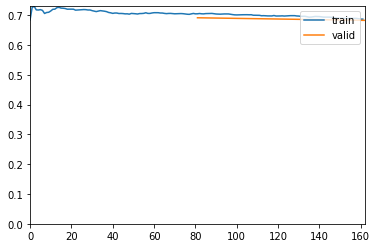

Better model found at epoch 1 with valid_loss value: 0.6830155849456787.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.679900,0.679835,0.550459,0.534682,0.581761,00:56
1,0.683574,0.678388,0.562691,0.548780,0.566038,00:56
2,0.679959,0.675622,0.561162,0.542700,0.619497,00:56
3,0.674613,0.671937,0.579511,0.570492,0.547170,00:56
4,0.673626,0.668354,0.579511,0.563050,0.603774,00:56
5,0.666210,0.664538,0.588685,0.580858,0.553459,00:56
6,0.666443,0.662466,0.588685,0.567867,0.644654,00:56
7,0.662239,0.658263,0.593272,0.588435,0.544025,00:56
8,0.658026,0.657387,0.594801,0.574230,0.644654,00:56
9,0.652988,0.654249,0.605505,0.594937,0.591195,00:56


Better model found at epoch 0 with valid_loss value: 0.6798352003097534.


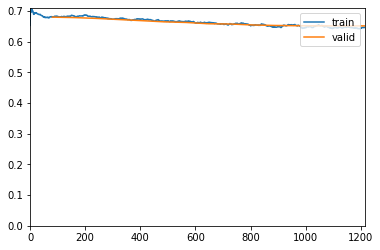

Better model found at epoch 1 with valid_loss value: 0.6783875823020935.
Better model found at epoch 2 with valid_loss value: 0.6756224632263184.
Better model found at epoch 3 with valid_loss value: 0.6719374060630798.
Better model found at epoch 4 with valid_loss value: 0.6683539748191833.
Better model found at epoch 5 with valid_loss value: 0.6645379662513733.
Better model found at epoch 6 with valid_loss value: 0.6624658107757568.
Better model found at epoch 7 with valid_loss value: 0.6582625508308411.
Better model found at epoch 8 with valid_loss value: 0.6573867797851562.
Better model found at epoch 9 with valid_loss value: 0.6542489528656006.
Better model found at epoch 10 with valid_loss value: 0.6526821255683899.
Better model found at epoch 11 with valid_loss value: 0.6519389748573303.
Better model found at epoch 12 with valid_loss value: 0.6515828371047974.
Better model found at epoch 13 with valid_loss value: 0.6513408422470093.
Better model found at epoch 14 with valid_loss 

In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

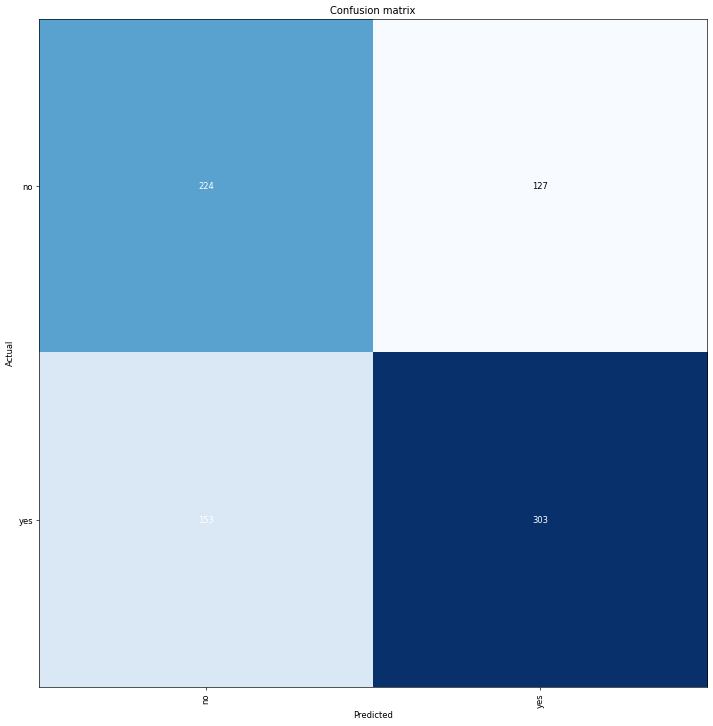

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6530359387397766.


(#4) [0.6414331197738647,0.6530359387397766,0.7046511627906977,0.6644736842105263]

## Faltten

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.724316,0.695893,0.486239,0.486239,1.000000,00:55
1,0.701332,0.695223,0.513761,0.000000,0.000000,00:55


Better model found at epoch 0 with valid_loss value: 0.695892870426178.


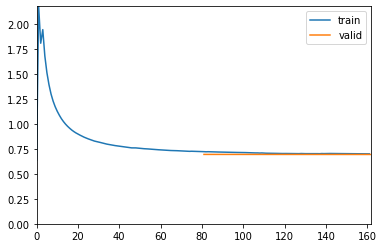

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with valid_loss value: 0.695222795009613.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=0.14454397559165955)

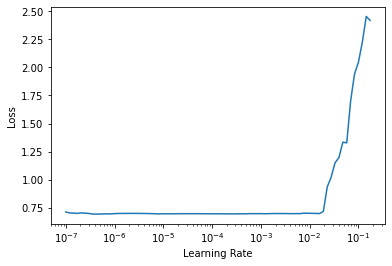

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.812862,0.692719,0.513761,0.000000,0.000000,00:55
1,0.745928,0.692955,0.513761,0.000000,0.000000,00:55
2,0.711890,0.707403,0.486239,0.486239,1.000000,00:55
3,0.700344,0.692914,0.513761,0.000000,0.000000,00:55


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.6927194595336914.


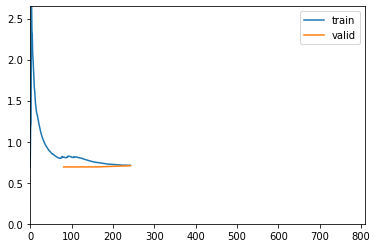

No improvement since epoch 0: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


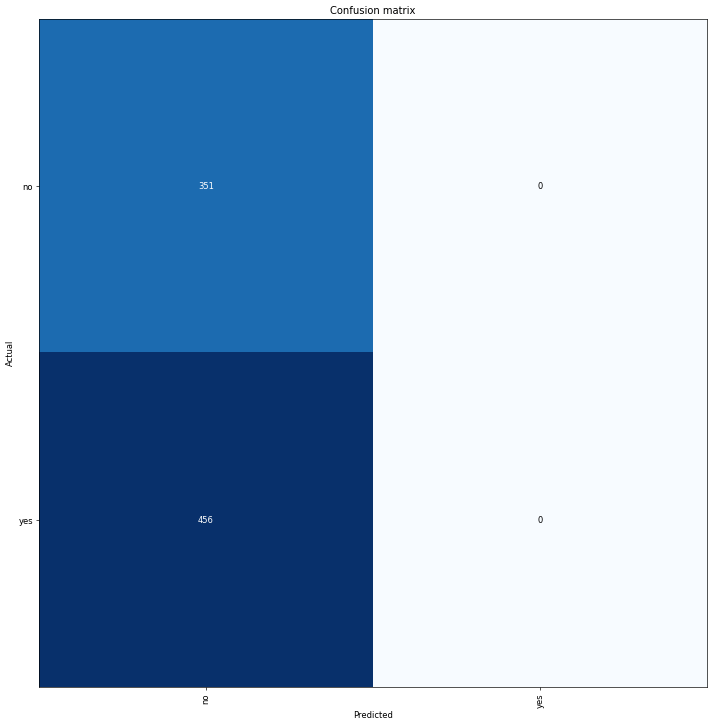

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.6986132264137268,0.4349442422389984,0.0,0.0]

## LabelSmoothing

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=9.12010818865383e-07)

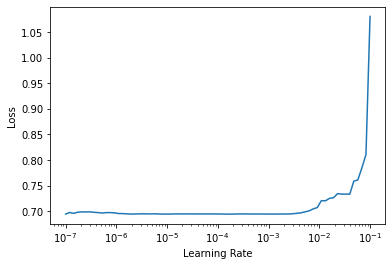

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.699580,0.696139,0.486239,0.486239,1.000000,00:56
1,0.707902,0.697459,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.6961386203765869.


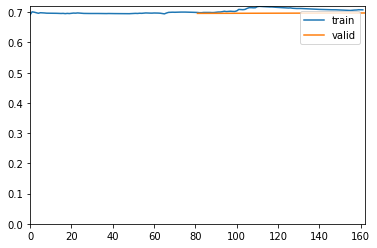

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.696424,0.696159,0.486239,0.486239,1.000000,00:55
1,0.699809,0.721241,0.513761,0.000000,0.000000,00:55
2,0.701171,0.745327,0.486239,0.486239,1.000000,00:55
3,0.702371,0.701910,0.513761,0.000000,0.000000,00:55


Better model found at epoch 0 with valid_loss value: 0.6961588859558105.


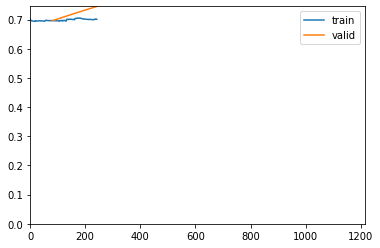

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 0: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

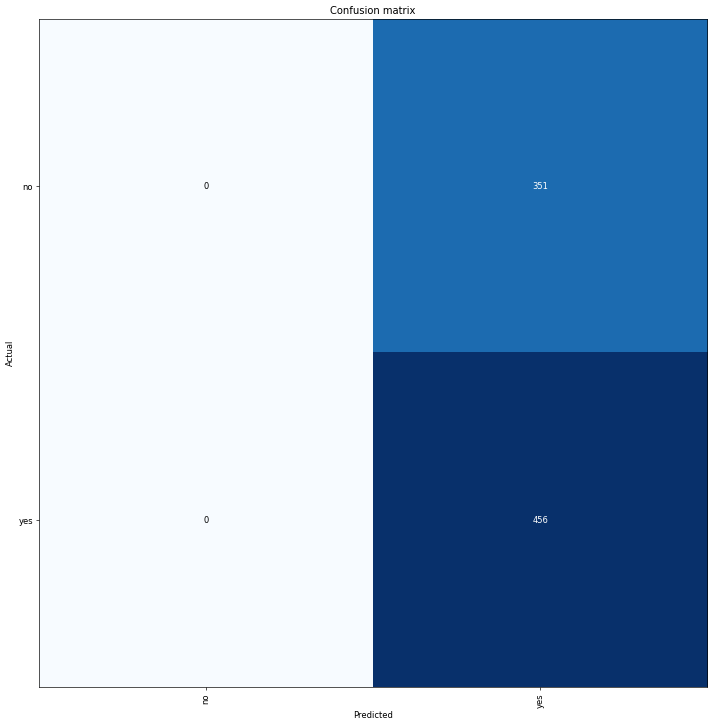

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6880226135253906,0.565055787563324,0.5650557620817844,1.0]

## MixUp

In [ ]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.698368,0.733288,0.486239,0.486239,1.000000,00:56
1,0.710067,0.717199,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.7332876324653625.


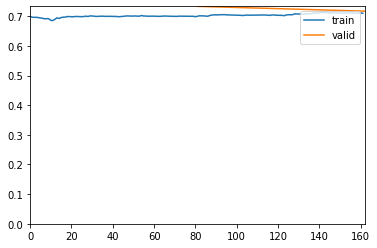

Better model found at epoch 1 with valid_loss value: 0.7171990871429443.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.695921,0.700342,0.486239,0.486239,1.000000,00:55
1,0.696895,0.700901,0.513761,0.000000,0.000000,00:56
2,0.701264,0.710295,0.486239,0.486239,1.000000,00:56
3,0.698110,0.697438,0.486239,0.486239,1.000000,00:56
4,0.697053,0.699867,0.513761,0.000000,0.000000,00:56
5,0.698942,0.693367,0.489297,0.487461,0.977987,00:56
6,0.696901,0.694898,0.486239,0.486239,1.000000,00:56
7,0.696766,0.697523,0.486239,0.486239,1.000000,00:56
8,0.695331,0.693685,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.7003419995307922.


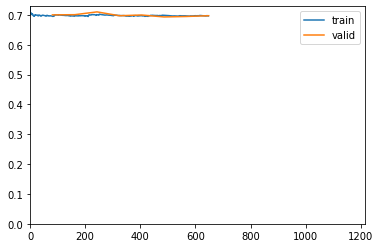

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.6974381804466248.
Better model found at epoch 5 with valid_loss value: 0.6933669447898865.
No improvement since epoch 5: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

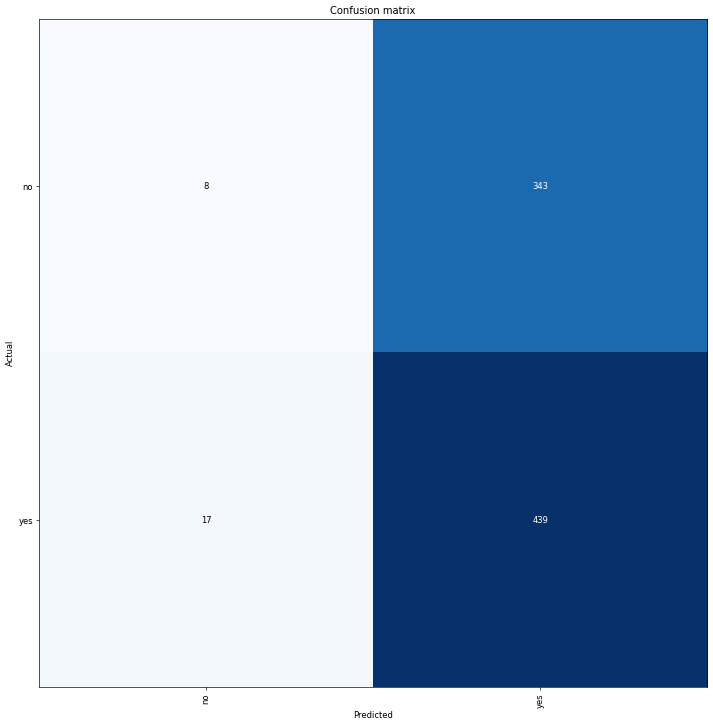

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.553903341293335.


(#4) [0.6926261186599731,0.553903341293335,0.5613810741687979,0.9627192982456141]

## Ranger + Flat cosin Anneal

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693020,0.693812,0.486239,0.486239,1.000000,00:56
1,0.693159,0.694216,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.6938115954399109.


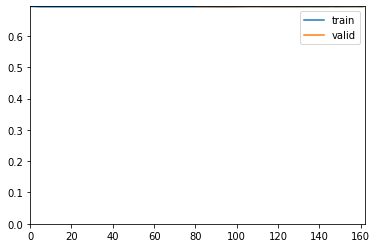

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.25118863582611084)

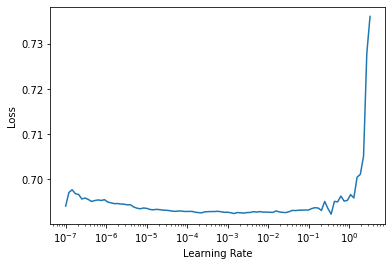

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693590,0.693159,0.513761,0.000000,0.000000,00:55
1,0.695109,0.692973,0.513761,0.000000,0.000000,00:56
2,0.693455,0.700261,0.486239,0.486239,1.000000,00:56
3,0.694344,0.693769,0.486239,0.486239,1.000000,00:56
4,0.692941,0.696272,0.486239,0.486239,1.000000,00:56


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.6931594014167786.


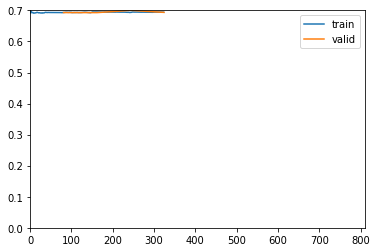

Better model found at epoch 1 with valid_loss value: 0.6929728388786316.
No improvement since epoch 1: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.6949334144592285,0.4349442422389984,0.0,0.0]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693183,0.693351,0.487768,0.486698,0.977987,00:56
1,0.693748,0.694739,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.6933509707450867.


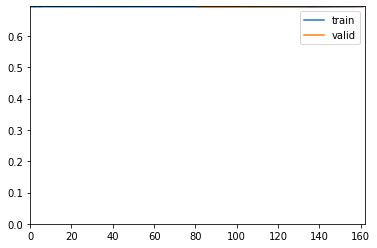

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

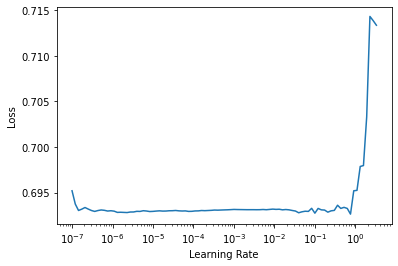

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693948,0.695099,0.486239,0.486239,1.000000,00:56
1,0.693849,0.693361,0.487768,0.486781,0.984277,00:56
2,0.693857,0.693335,0.490826,0.488076,0.965409,00:56
3,0.694074,0.696489,0.486239,0.486239,1.000000,00:56
4,0.695204,0.692976,0.513761,0.000000,0.000000,00:56
5,0.693892,0.693111,0.513761,0.000000,0.000000,00:56
6,0.694756,0.695388,0.486239,0.486239,1.000000,00:56
7,0.695012,0.693613,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.6950985789299011.


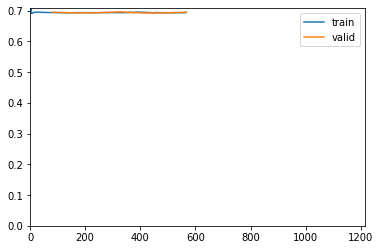

Better model found at epoch 1 with valid_loss value: 0.6933605670928955.
Better model found at epoch 2 with valid_loss value: 0.6933349967002869.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 4 with valid_loss value: 0.6929759383201599.
No improvement since epoch 4: early stopping


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.6976938247680664,0.4349442422389984,0.0,0.0]

## Ranger +Flat + Label + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693831,0.693598,0.486239,0.486239,1.000000,00:56
1,0.693239,0.693307,0.478593,0.480409,0.886792,00:56


Better model found at epoch 0 with valid_loss value: 0.6935980319976807.


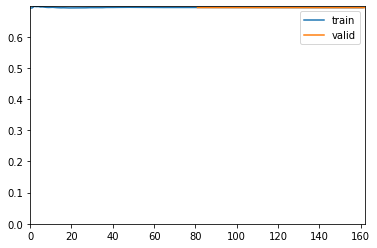

Better model found at epoch 1 with valid_loss value: 0.693306565284729.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693836,0.693995,0.486239,0.486239,1.000000,00:56
1,0.693493,0.694227,0.486239,0.486239,1.000000,00:56
2,0.695294,0.695994,0.486239,0.486239,1.000000,00:56
3,0.695242,0.693003,0.513761,0.000000,0.000000,00:56
4,0.694236,0.695061,0.486239,0.486239,1.000000,00:56
5,0.693665,0.693548,0.484709,0.485452,0.996855,00:56
6,0.693700,0.696811,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.6939949989318848.


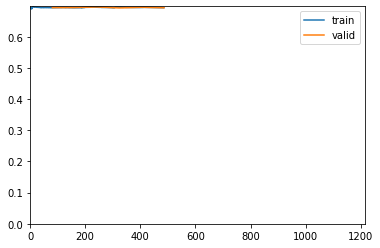

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.6930025815963745.
No improvement since epoch 3: early stopping


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


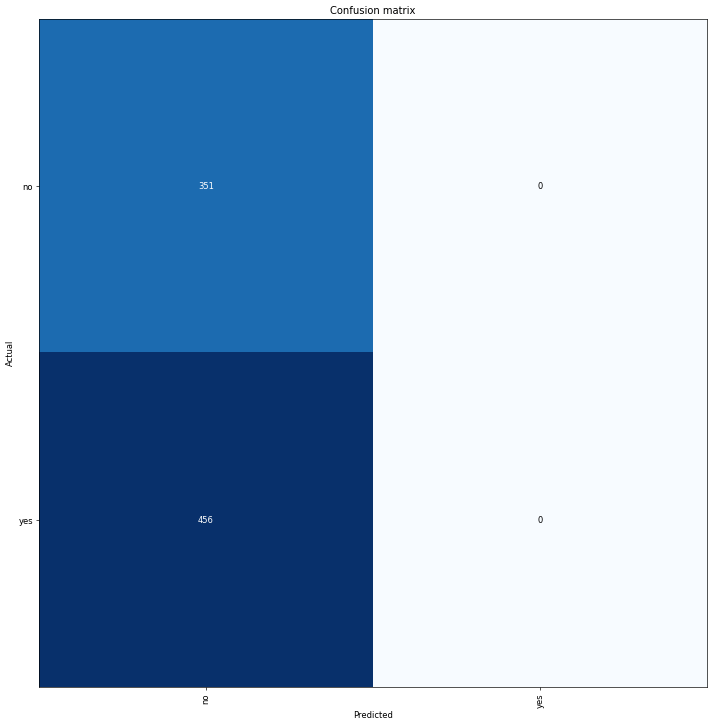

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.6948256492614746,0.4349442422389984,0.0,0.0]

## Ranger + Flat + MixUp

In [ ]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693238,0.693673,0.486239,0.486239,1.000000,00:56
1,0.693065,0.693492,0.483180,0.484663,0.993711,00:56


Better model found at epoch 0 with valid_loss value: 0.6936730146408081.


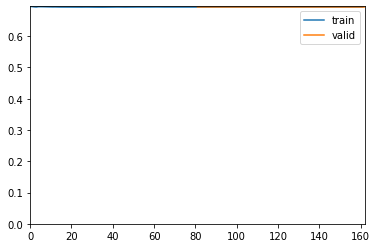

Better model found at epoch 1 with valid_loss value: 0.6934919953346252.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.694308,0.693852,0.486239,0.486239,1.000000,00:56
1,0.694925,0.698730,0.486239,0.486239,1.000000,00:56
2,0.693597,0.698843,0.486239,0.486239,1.000000,00:56
3,0.698361,0.694425,0.486239,0.486239,1.000000,00:56


Better model found at epoch 0 with valid_loss value: 0.6938518285751343.


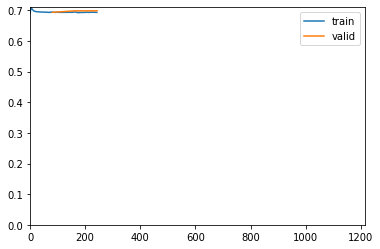

No improvement since epoch 0: early stopping


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.691118597984314,0.565055787563324,0.5650557620817844,1.0]

## Ranger + MixUp

In [ ]:
# opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.700533,0.679682,0.570336,0.577114,0.676385,01:47
1,0.695854,0.684781,0.539755,0.628049,0.300292,01:47


Better model found at epoch 0 with valid_loss value: 0.6796822547912598.


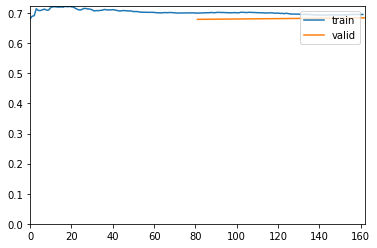

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.694832,0.679156,0.570336,0.579082,0.661808,01:47
1,0.693039,0.678232,0.577982,0.589333,0.644315,01:47
2,0.694668,0.676750,0.582569,0.606061,0.583090,01:47
3,0.687782,0.675299,0.579511,0.625000,0.495627,01:47
4,0.685714,0.667825,0.584098,0.591731,0.667638,01:47
5,0.681492,0.665267,0.591743,0.604396,0.641399,01:47
6,0.678281,0.669459,0.594801,0.661157,0.466472,01:47
7,0.676894,0.661826,0.602446,0.623881,0.609329,01:47
8,0.672571,0.661085,0.607034,0.635220,0.588921,01:47
9,0.673921,0.662377,0.622324,0.666667,0.559767,01:47


Better model found at epoch 0 with valid_loss value: 0.6791560649871826.


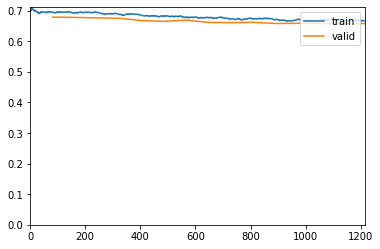

Better model found at epoch 1 with valid_loss value: 0.6782320141792297.
Better model found at epoch 2 with valid_loss value: 0.6767501831054688.
Better model found at epoch 3 with valid_loss value: 0.6752994060516357.
Better model found at epoch 4 with valid_loss value: 0.667824923992157.
Better model found at epoch 5 with valid_loss value: 0.6652669310569763.
Better model found at epoch 7 with valid_loss value: 0.6618260145187378.
Better model found at epoch 8 with valid_loss value: 0.6610851287841797.
Better model found at epoch 10 with valid_loss value: 0.6582967042922974.
Better model found at epoch 13 with valid_loss value: 0.6580532789230347.
Better model found at epoch 14 with valid_loss value: 0.6579842567443848.


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6443618535995483.


(#4) [0.6553453803062439,0.6443618535995483,0.7016706443914081,0.6447368421052632]

## Faltten + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.719282,0.699256,0.475535,0.000000,0.000000,01:45
1,0.700496,0.697464,0.475535,0.000000,0.000000,01:45


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.6992564797401428.


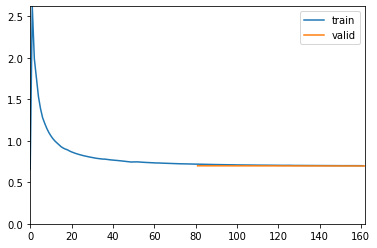

Better model found at epoch 1 with valid_loss value: 0.6974635720252991.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.848592,0.718476,0.475535,0.000000,0.000000,01:44
1,0.742996,0.765033,0.524465,0.524465,1.000000,01:44
2,0.736850,0.697043,0.524465,0.524465,1.000000,01:45
3,0.703972,0.696143,0.475535,0.000000,0.000000,01:45
4,0.695855,0.692173,0.524465,0.524465,1.000000,01:45
5,0.694949,0.693607,0.475535,0.000000,0.000000,01:45
6,0.702220,0.692176,0.524465,0.524465,1.000000,01:44
7,0.698987,0.692199,0.524465,0.524465,1.000000,01:44


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.7184761762619019.


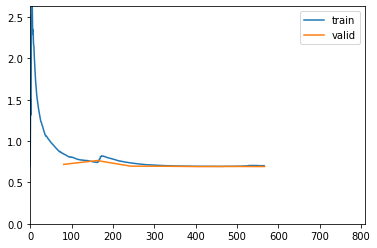

Better model found at epoch 2 with valid_loss value: 0.6970430016517639.
Better model found at epoch 3 with valid_loss value: 0.6961433291435242.
Better model found at epoch 4 with valid_loss value: 0.6921732425689697.
No improvement since epoch 4: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6899133324623108,0.565055787563324,0.5650557620817844,1.0]

## Ranger + Label

In [ ]:
# opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693621,0.692314,0.524465,0.524465,1.000000,01:45
1,0.693466,0.692339,0.524465,0.524465,1.000000,01:45


Better model found at epoch 0 with valid_loss value: 0.6923141479492188.


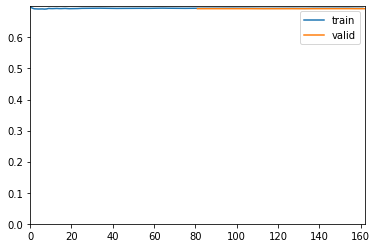

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693617,0.692316,0.524465,0.524465,1.000000,01:45
1,0.693775,0.692322,0.524465,0.524465,1.000000,01:45
2,0.693416,0.692334,0.524465,0.524465,1.000000,01:45
3,0.693598,0.692348,0.524465,0.524465,1.000000,01:45


Better model found at epoch 0 with valid_loss value: 0.6923162937164307.


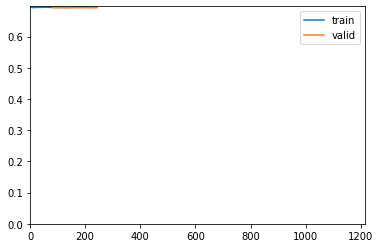

No improvement since epoch 0: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6903144121170044,0.565055787563324,0.5650557620817844,1.0]

## Faltten + Label

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693693,0.692179,0.524465,0.524465,1.000000,01:45
1,0.693785,0.693427,0.475535,0.000000,0.000000,01:44


Better model found at epoch 0 with valid_loss value: 0.6921789050102234.


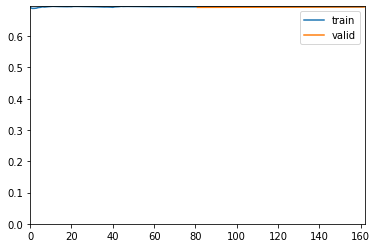

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.033113110810518265)

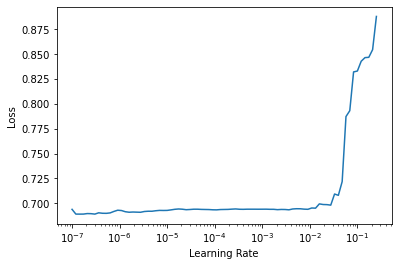

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.699970,0.692212,0.524465,0.524465,1.000000,01:45
1,0.695214,0.692276,0.524465,0.524465,1.000000,01:44
2,0.697889,0.694559,0.475535,0.000000,0.000000,01:44
3,0.711288,0.702111,0.475535,0.000000,0.000000,01:44


Better model found at epoch 0 with valid_loss value: 0.6922116279602051.


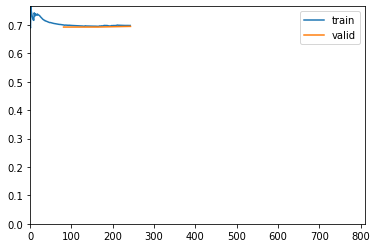

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 0: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6896050572395325,0.565055787563324,0.5650557620817844,1.0]

## Label + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693695,0.692555,0.524465,0.524465,1.000000,01:45
1,0.693703,0.692548,0.524465,0.524465,1.000000,01:45


Better model found at epoch 0 with valid_loss value: 0.6925548911094666.


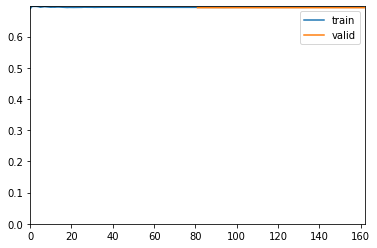

Better model found at epoch 1 with valid_loss value: 0.6925478577613831.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693373,0.692713,0.524465,0.524465,1.000000,01:45
1,0.693336,0.692584,0.524465,0.524465,1.000000,01:44
2,0.693414,0.693118,0.524465,0.524465,1.000000,01:44
3,0.693617,0.693262,0.475535,0.000000,0.000000,01:45
4,0.693540,0.692915,0.524465,0.524465,1.000000,01:45


Better model found at epoch 0 with valid_loss value: 0.6927130222320557.


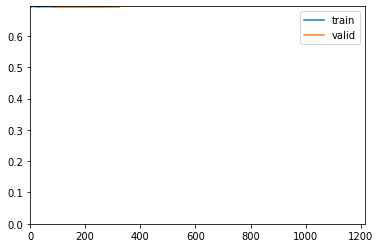

Better model found at epoch 1 with valid_loss value: 0.6925840377807617.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 1: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6914505958557129,0.565055787563324,0.5650557620817844,1.0]